In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os
os.chdir("/content/drive/My Drive/VR27/Mask_RCNN")

In [ ]:
!mkdir vr2

In [ ]:
!pip uninstall tensorflow
!pip uninstall keras 
!pip install tensorflow==2.5
!pip install keras

In [ ]:
import numpy as np
import cv2
import mrcnn.config
import mrcnn.utils
from mrcnn.model import MaskRCNN
from pathlib import Path
import matplotlib as pt

In [ ]:
# Mask-RCNN config
class MaskRCNNConfig(mrcnn.config.Config):
    NAME = "coco_pretrained_model_config"
    IMAGES_PER_GPU = 1
    GPU_COUNT = 1
    NUM_CLASSES = 1 + 80  
    DETECTION_MIN_CONFIDENCE = 0.6 
config=MaskRCNNConfig()   
# Filter to only cars
def get_car_boxes(boxes, class_ids):
    car_boxes = []

    for i, box in enumerate(boxes):
        if class_ids[i] in [3, 8, 6]:
            car_boxes.append(box)

    return np.array(car_boxes)

    # Twilio config
twilio_account_sid = 'aaaaaaaaaaaaaaaaaaaaa'
twilio_auth_token = 'aaaaaaaaaaaaaa'
twilio_phone_number = '+9999999'
destination_phone_number = '+199999999'
client = Client(twilio_account_sid, twilio_auth_token)
# Root dir
ROOT_DIR = Path(".")

#Trained model loc
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

if not os.path.exists(COCO_MODEL_PATH):
    mrcnn.utils.download_trained_weights(COCO_MODEL_PATH)

In [ ]:
VIDEO_SOURCE = "test_images/parking_lot_3.mp4"

model = MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

model.load_weights(COCO_MODEL_PATH, by_name=True)

Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Instructions for updating:
Use fn_output_signature instead


Current frame counter0


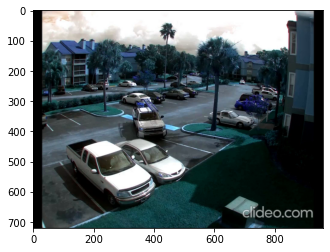

Current frame counter5


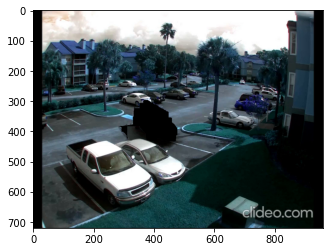

Current frame counter10


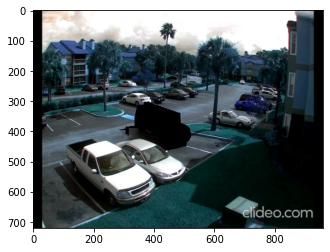

Current frame counter15


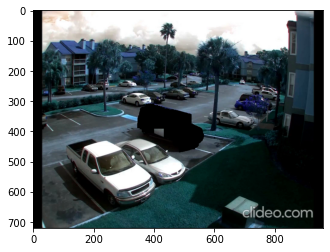

Current frame counter20


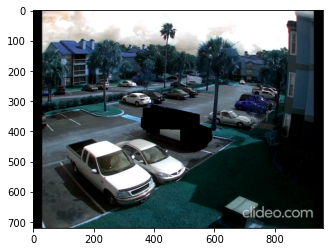

Current frame counter25


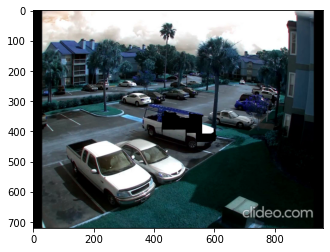

Current frame counter30


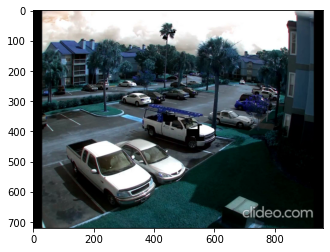

Current frame counter35


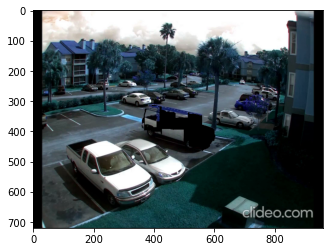

going in to mark vehicles. Frame number:   41


Exception ignored in: <function IteratorResourceDeleter.__del__ at 0x7f9eec4d90e0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/data/ops/iterator_ops.py", line 546, in __del__
    handle=self._handle, deleter=self._deleter)
  File "/usr/local/lib/python3.7/dist-packages/tensorflow/python/ops/gen_dataset_ops.py", line 1264, in delete_iterator
    _ctx, "DeleteIterator", name, handle, deleter)
KeyboardInterrupt: 


couldn't read video
Video finished


In [ ]:
# spotted parking spaces
parked_car_boxes = None

video_capture = cv2.VideoCapture(VIDEO_SOURCE)

free_space_frames = 0
sms_sent = False
count = 0
temp = np.array(4,)

parked_car_boxes1 = [None] * 11

def checkEqual2(iterator):
   print(iterator)
#     return len(set(iterator)) <= 1
  
# Loop over each frame in the video
counter = 0
ref_image = None
ref_image_color = None
cumm_image = None
img_thresh_sub1 = None
final_ref = None
while video_capture.isOpened():
    success, frame = video_capture.read()
    
    #image = frame
    if not success:
        print("couldn't read video")
        break
        
    elif counter<40:
      #create another video reader object to compare the two frames and verify the possibility of motion
      success, frame2 = video_capture.read()
      d = cv2.absdiff(frame, frame2)  
      grey = cv2.cvtColor(d, cv2.COLOR_BGR2GRAY)
      blur = cv2.GaussianBlur(grey, (1, 1), 0)
      ret, th = cv2.threshold( blur, 20, 255, cv2.THRESH_BINARY)
      
     
      dilated = cv2.dilate(th, np.ones((30, 30), np.uint8), iterations=1 )
      eroded = cv2.erode(dilated, np.ones((30, 30), np.uint8), iterations=1 )
        

      c, h = cv2.findContours(eroded, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
      frame2 = cv2.drawContours(frame2, c, -1, (0,0,0), cv2.FILLED)
          
      if counter%5 == 0:
        print("Current frame counter" + str(counter))
        pt.pyplot.imshow(frame2)
        pt.pyplot.show()
        
      counter = counter + 1
      continue
    
    # Converting the image from BGR color used by OpenCV to RGB color. 
    if counter==40:
      rgb_image = frame2[:,:,::-1]
      counter+=1
    else:
      rgb_image = frame[:, :, ::-1]
      
    results = model.detect([rgb_image], verbose=0)
    r = results[0]
    if parked_car_boxes is None:
        print("going in to mark vehicles. Frame number:  ", counter)
        video_capture = cv2.VideoCapture(VIDEO_SOURCE)
        
        parked_car_boxes = get_car_boxes(r['rois'], r['class_ids'])
          
    else:
        # Get where cars are currently located in the frame
        car_boxes = get_car_boxes(r['rois'], r['class_ids'])

        # See how much those cars overlap with the known parking spaces
        overlaps = mrcnn.utils.compute_overlaps(parked_car_boxes, car_boxes)

        # Assume no spaces are free until we find one that is free
        free_space = False

        # Loop through each known parking space box
        for parking_area, overlap_areas in zip(parked_car_boxes, overlaps):

            
            max_IoU_overlap = np.max(overlap_areas)

            y1, x1, y2, x2 = parking_area
            if max_IoU_overlap < 0.15:
                # Parking space not occupied! Draw a green box around it
                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 3)
                
                free_space = True
            else:
                # Parking space is still occupied - draw a red box around it
                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 0, 255), 1)

            # Write the IoU measurement inside the box
            font = cv2.FONT_HERSHEY_DUPLEX
            cv2.putText(frame, f"{max_IoU_overlap:0.2}", (x1 + 6, y2 - 6), font, 0.3, (255, 255, 255))

       
        if free_space:
            free_space_frames += 1
        else:
            # If no spots are free, reset the count
            free_space_frames = 0

        # If a space has been free for several frames, we are pretty sure it is really free!
        if free_space_frames > 120:
            # Write SPACE AVAILABLE!! at the top of the screen
            font = cv2.FONT_HERSHEY_DUPLEX
            cv2.putText(frame, f"SPACE AVAILABLE!", (10, 150), font, 3.0, (0, 255, 0), 2, cv2.FILLED)
            
         # If we haven't sent an SMS yet, sent it!
            if not sms_sent:
                print("SENDING SMS!!!")
                message = client.messages.create(
                    body="Parking space available!!!",
                    from_=twilio_phone_number,
                    to=destination_phone_number
                )
                sms_sent = True
                print("Hope you got the message on your phone")   

        # Show the frame of video on the screen
#         cv2.imshow('Video', frame)
    #saving each frame
    name = str(count) + ".jpg"
    name = os.path.join('./vr2', name)
    cv2.imwrite(name, frame)
    count+=1
    
    #'q' to quit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Clean up
print("Video finished")
video_capture.release()
# cv2.destroyAllWindows()

In [ ]:
#create video including all the frames in the vr folder
import glob

images = list(glob.iglob(os.path.join('./vr2', '*.*')))
images = sorted(images, key=lambda x: float(os.path.split(x)[1][:-3]))


img_array = []

for image in images:
    img = cv2.imread(image)
    height, width, layers = img.shape
    size = (width,height)
    img_array.append(img)
 
out = cv2.VideoWriter('output2.mp4',cv2.VideoWriter_fourcc(*'FMP4'), 15, size)
 
for i in range(len(img_array)):
    out.write(img_array[i])
out.release()